# Anomalie Detection


## Sesonal Decompose

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
import opendatasets as od


# Daten


In [3]:
# url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
# df = pd.read_csv(url, index_col=0, parse_dates=True)
#get data from ambient_temperature_system_failure.csv
path = "ambient_temperature_system_failure.csv"
df = pd.read_csv(path, index_col=0, parse_dates=True)

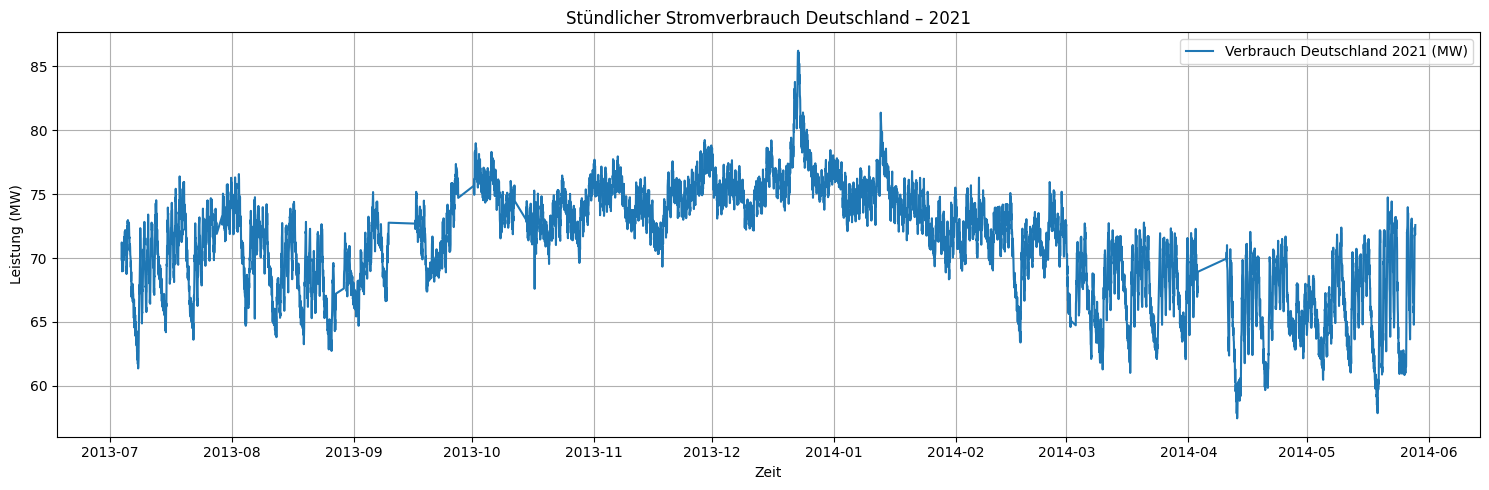

In [4]:


series = df["value"]
series.index = pd.to_datetime(series.index)  # das ist entscheidend

# 2. Fehlende Werte interpolieren
series = series.interpolate().dropna()

# # # # 3. Nur Daten aus 2021 extrahieren
# series = series.loc["2020"]


# 4. Plotten
plt.figure(figsize=(15, 5))
plt.plot(series, label="Verbrauch Deutschland 2021 (MW)")
plt.title("Stündlicher Stromverbrauch Deutschland – 2021")
plt.xlabel("Zeit")
plt.ylabel("Leistung (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# LSTM Modell zur vorhersage und Anomalie erkennung

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Aufteilen in Training (bis 2019) und Test (2020) ---
train_series = series[series.index < "2014-04-01"]
test_series = series[(series.index >= "2014-04-01")]

# --- Normalisieren ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_series.values.reshape(-1, 1))

# --- Funktion zum Erstellen von Sequenzen mit Zeitfeatures ---
def create_sequences_with_time_features(data, timestamps, lookback=168):
    X, y = [], []
    for i in range(lookback, len(data)):
        # Zeitfeatures berechnen
        time_of_day = timestamps[i].hour / 24.0
        day_of_week = timestamps[i].weekday() / 7.0
        month_of_year = timestamps[i].month / 12.0

        # Sinus- und Kosinus-Transformation
        time_features = [
            np.sin(2 * np.pi * time_of_day), np.cos(2 * np.pi * time_of_day),
            np.sin(2 * np.pi * day_of_week), np.cos(2 * np.pi * day_of_week),
            np.sin(2 * np.pi * month_of_year), np.cos(2 * np.pi * month_of_year)
        ]

        # Sequenz erstellen
        X_seq = np.hstack([data[i - lookback:i], np.tile(time_features, (lookback, 1))])
        X.append(X_seq)
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 168
X_train, y_train = create_sequences_with_time_features(train_scaled, train_series.index, lookback)
X_test, y_test = create_sequences_with_time_features(test_scaled, test_series.index, lookback)

In [6]:
print(f"X_test first values: {X_test[:5]} ")
print(f"y_test first values: {y_test[:5]} ")

X_test first values: [[[ 2.89949979e-01  9.65925826e-01  2.58819045e-01 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  [ 2.15005138e-01  9.65925826e-01  2.58819045e-01 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  [ 2.44929269e-01  9.65925826e-01  2.58819045e-01 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  ...
  [ 9.88672446e-02  9.65925826e-01  2.58819045e-01 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  [ 1.36892103e-01  9.65925826e-01  2.58819045e-01 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  [ 9.93168232e-02  9.65925826e-01  2.58819045e-01 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]]

 [[ 2.15005138e-01  1.00000000e+00  6.12323400e-17 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  [ 2.44929269e-01  1.00000000e+00  6.12323400e-17 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  [ 2.48205066e-01  1.00000000e+00  6.12323400e-17 ...  6.23489802e-01
    8.66025404e-01 -5.00000000e-01]
  ...
  

In [7]:
# ----- 2. LSTM-Modell -----
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(InputLayer(input_shape=(lookback, X_train.shape[2])))  # Explicit input layer
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(),metrics =[RootMeanSquaredError()])
model.summary()
cp = ModelCheckpoint('model1.keras', save_best_only=True)
# ----- 3. Training -----
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1, callbacks=[cp])

c:\Users\STI\Desktop\Eliona\Anomalie_Detection\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0181 - root_mean_squared_error: 0.1260 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0015 - root_mean_squared_error: 0.0381 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0485
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483


In [8]:
from tensorflow.keras.models import load_model
# Laden des besten Modells
model = load_model('model1.keras')
# ----- 4. Vorhersage -----
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(f"y_pred_train shape: {y_pred_train.shape}")
print(f"y_pred_test shape: {y_pred_test.shape}")
# ----- 5. Schwellenwert berechnen (z. B. 99%-Quantil des Trainingsfehlers) -----
train_mae = np.abs(y_pred_train - y_train)
threshold = np.quantile(train_mae, 0.99)
print(f"Anomalie-Schwelle (99%-Quantil MAE im Training): {threshold:.5f}")

# ----- 6. Fehler auf Testdaten & Anomalieerkennung -----
test_mae = np.abs(y_pred_test - y_test)
anomalies = test_mae > threshold

# ----- 7. Zurückskalieren -----
y_test_inv = scaler.inverse_transform(y_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)



X_train shape: (5888, 168, 7)
X_test shape: (1043, 168, 7)
y_train shape: (5888, 1)
y_test shape: (1043, 1)
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
y_pred_train shape: (5888, 1)
y_pred_test shape: (1043, 1)
Anomalie-Schwelle (99%-Quantil MAE im Training): 0.09681


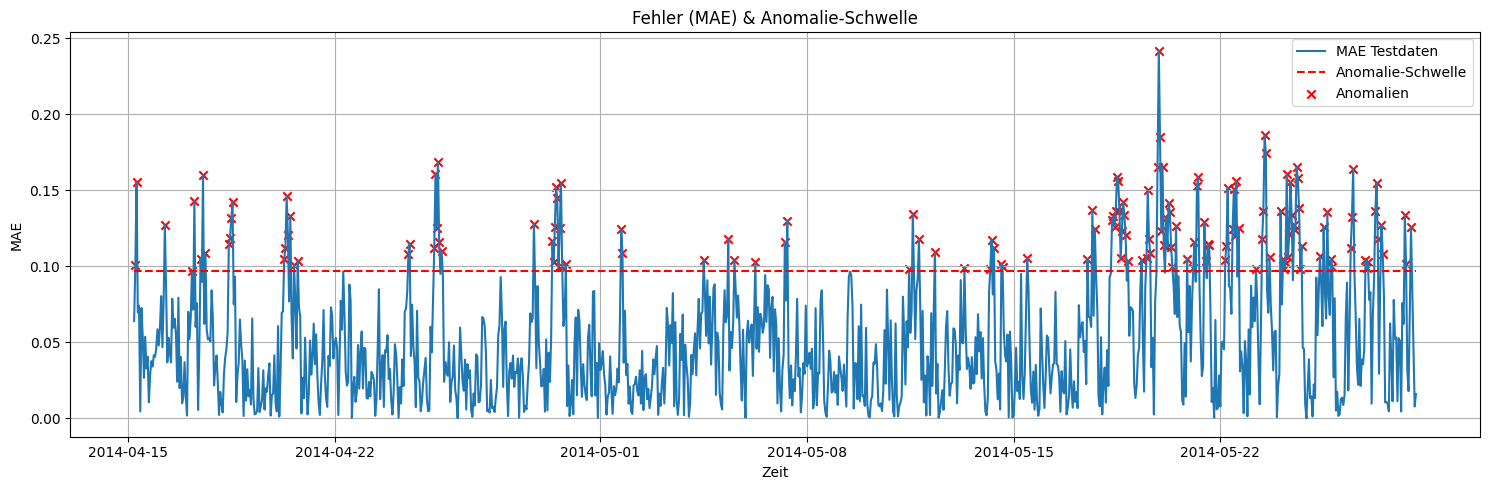

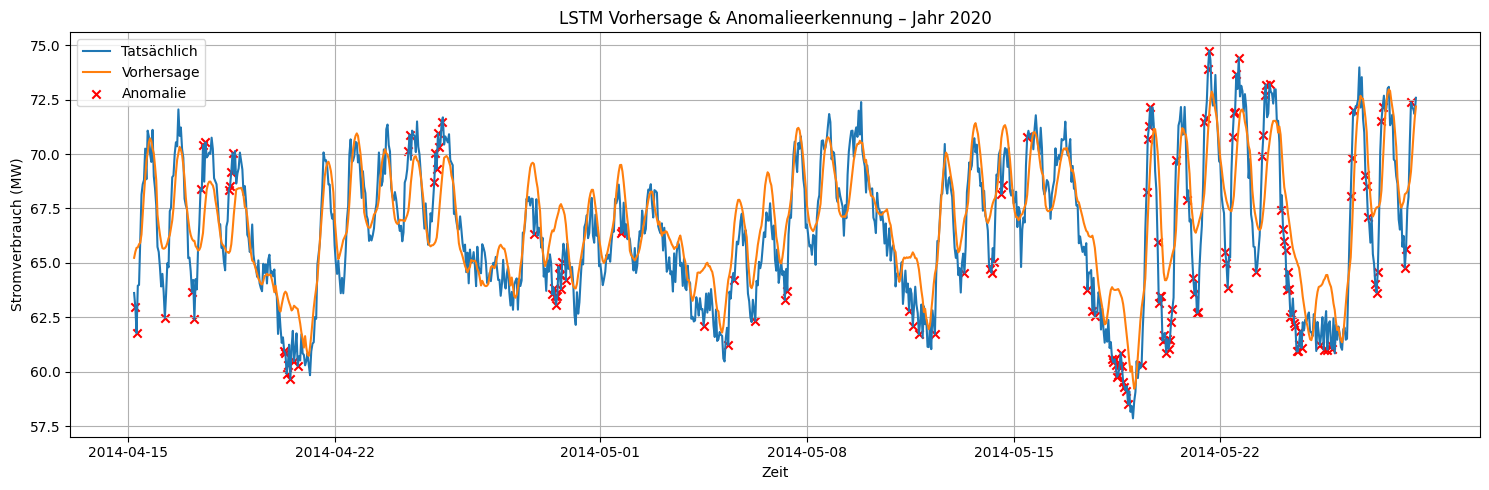

In [9]:
# ----- 8. Visualisierung -----

# Erzeuge Index für Vorhersage-Zeiten (die zu y_test/y_pred_test gehören)
test_index = test_series.index[lookback:]

# Umwandlung in NumPy, falls nötig
y_test_inv = y_test_inv.flatten()
y_pred_test_inv = y_pred_test_inv.flatten()
test_mae = test_mae.flatten()
anomalies = anomalies.flatten()

# Timestamps, an denen Anomalien erkannt wurden
anomaly_timestamps = test_index[anomalies]
# Fehler (MAE) im Zeitverlauf + Threshold
plt.figure(figsize=(15, 5))
plt.plot(test_index, test_mae, label="MAE Testdaten")
plt.hlines(threshold, test_index.min(), test_index.max(),
           colors='red', linestyles='--', label="Anomalie-Schwelle")
# Punkte, die als Anomalie markiert wurden
plt.scatter(test_index[anomalies], test_mae[anomalies],
            color='red', marker='x', label="Anomalien")
plt.title("Fehler (MAE) & Anomalie-Schwelle")
plt.xlabel("Zeit")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test_index, y_test_inv, label="Tatsächlich")
plt.plot(test_index, y_pred_test_inv, label="Vorhersage")
plt.scatter(anomaly_timestamps, y_test_inv[anomalies], color='red', label="Anomalie", marker='x')
plt.title("LSTM Vorhersage & Anomalieerkennung – Jahr 2020")
plt.xlabel("Zeit")
plt.ylabel("Stromverbrauch (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Probability modell zur anomalie erkennung

In [10]:
# -*- coding: utf-8 -*-
"""
Probabilistic LSTM‑basierte Anomalie‑Erkennung für Stromverbrauchs‑Zeitreihen
----------------------------------------------------------------------------
Benötigte Pakete (Install falls nötig)
    pip install tensorflow tensorflow-probability pandas scikit-learn matplotlib

Datei‑Aufbau
------------
1. Daten laden (CSV → pandas.Series `series` mit DateTimeIndex)
2. Train‑/Test‑Split und Normalisierung
3. Sequenzen mit Zeitfeatures generieren
4. Probabilistisches LSTM‑Modell (TF‑Probability) definieren
5. Training & Checkpoint
6. Vorhersage + 99 %-Konfidenzintervall
7. Anomalien markieren (Wert außerhalb PI)
8. Rückskalieren & Plotten

Hinweis: Das Skript ist schlank gehalten – für echtes Projekt Logging, hyperparameter tuning usw. ergänzen.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf          # TF 2.16 +
import tensorflow_probability as tfp
import tf_keras as tfk           # <--  Keras 2 API, von TFP unterstützt

tfd  = tfp.distributions
tfpl = tfp.layers




scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1)).astype(np.float32)
test_scaled = scaler.transform(test_series.values.reshape(-1, 1)).astype(np.float32)

# -----------------------------------------------------------------------------
# 3) Sequenzen mit Zeitfeatures erstellen
# -----------------------------------------------------------------------------

def create_sequences_with_time_features(data: np.ndarray,
                                        timestamps: pd.DatetimeIndex,
                                        lookback: int = 168):
    """Erzeugt X (Samples, lookback, features) & y (Samples, 1)"""
    X, y = [], []
    for i in range(lookback, len(data)):
        # Zeitfeatures (normiert auf [0,1])
        ts = timestamps[i]
        tod = ts.hour / 24.0
        dow = ts.weekday() / 7.0
        moy = ts.month / 12.0
        t_features = [
            np.sin(2 * np.pi * tod), np.cos(2 * np.pi * tod),
            np.sin(2 * np.pi * dow), np.cos(2 * np.pi * dow),
            np.sin(2 * np.pi * moy), np.cos(2 * np.pi * moy),
        ]
        seq = np.hstack(
            [data[i - lookback:i], np.tile(t_features, (lookback, 1))]
        )
        X.append(seq)
        y.append(data[i])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

lookback = 168  # 7 Tage bei stündlicher Auflösung
X_train, y_train = create_sequences_with_time_features(train_scaled, train_series.index, lookback)
X_test, y_test = create_sequences_with_time_features(test_scaled, test_series.index, lookback)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)





X_train: (5888, 168, 7) y_train: (5888, 1)
X_test : (1043, 168, 7) y_test : (1043, 1)


In [11]:
tf.random.set_seed(42)

inputs = tfk.Input(shape=(lookback, X_train.shape[2]))

x = tfk.layers.LSTM(64)(inputs)
x = tfk.layers.Dense(8, activation="relu")(x)

# 2 Parameter (µ, σ) pro Sample
params  = tfk.layers.Dense(tfpl.IndependentNormal.params_size(1))(x)
outputs = tfpl.IndependentNormal(1)(params)   # gibt tfd.Normal zurück

model = tfk.Model(inputs, outputs)

# Negative Log-Likelihood (NLL)
def nll(y, dist):
    return -dist.log_prob(y)

model.compile(optimizer=tfk.optimizers.Adam(1e-3), loss=nll)
model.summary()

cp = tfk.callbacks.ModelCheckpoint("model_prob.keras",
                                   save_best_only=True,
                                   monitor="val_loss",
                                   mode="min")



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal (Indepe  ((None, 1),               0         
 ndentNormal)                 (None, 1))                         
                                                                 
Total params: 18970 (74.10 KB)
Trainable params: 18970 (74.10 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [12]:
history =model.fit(X_train, y_train,
          epochs=10,
          validation_split=0.1,
          callbacks=[cp])


Epoch 1/10

166/166 [==============================] - 12s 62ms/step - loss: -0.7555 - val_loss: -1.1447
Epoch 2/10
  3/166 [..............................] - ETA: 7s - loss: -1.4963

c:\Users\STI\Desktop\Eliona\Anomalie_Detection\venv\Lib\site-packages\tf_keras\src\saving\serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: IndependentNormal.new(t, event_shape, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]


166/166 [==============================] - 10s 60ms/step - loss: -1.5981 - val_loss: -1.2544
Epoch 3/10
166/166 [==============================] - 8s 47ms/step - loss: -1.8438 - val_loss: -1.5720
Epoch 4/10
166/166 [==============================] - 8s 48ms/step - loss: -1.7507 - val_loss: -1.4209
Epoch 5/10
166/166 [==============================] - 9s 56ms/step - loss: -1.8867 - val_loss: -1.6646
Epoch 6/10
166/166 [==============================] - 9s 52ms/step - loss: -1.9192 - val_loss: -1.5508
Epoch 7/10
166/166 [==============================] - 8s 48ms/step - loss: -1.9500 - val_loss: -1.6195
Epoch 8/10
166/166 [==============================] - 8s 49ms/step - loss: -1.9756 - val_loss: -1.6905
Epoch 9/10
166/166 [==============================] - 8s 49ms/step - loss: -1.9019 - val_loss: -1.7453
Epoch 10/10
166/166 [==============================] - 9s 51ms/step - loss: -1.9603 - val_loss: -1.7270


Anomalien (Summe): 3


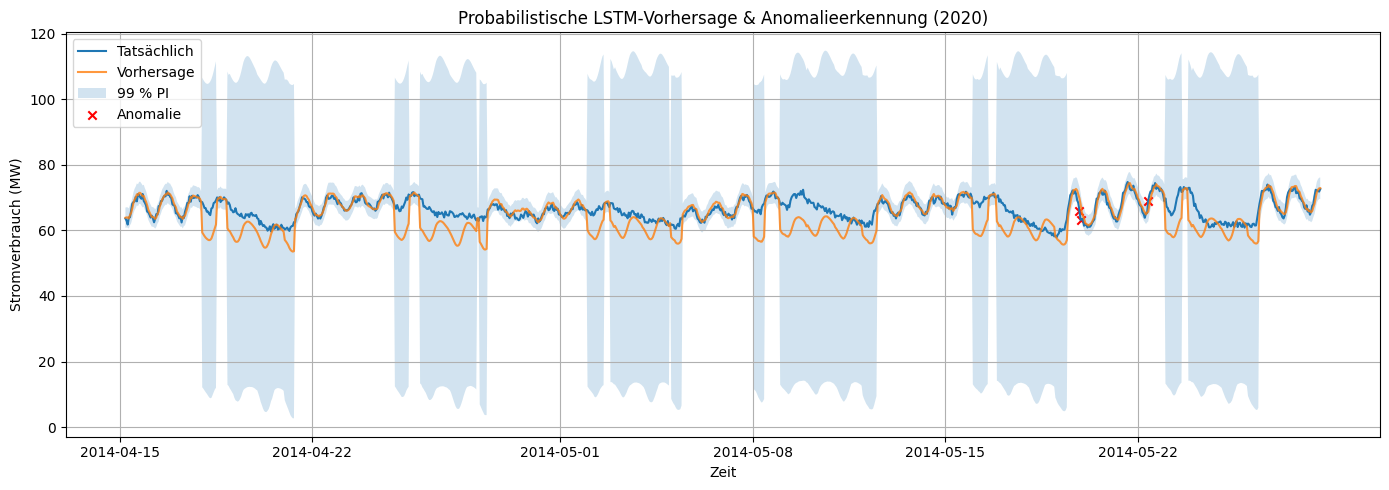

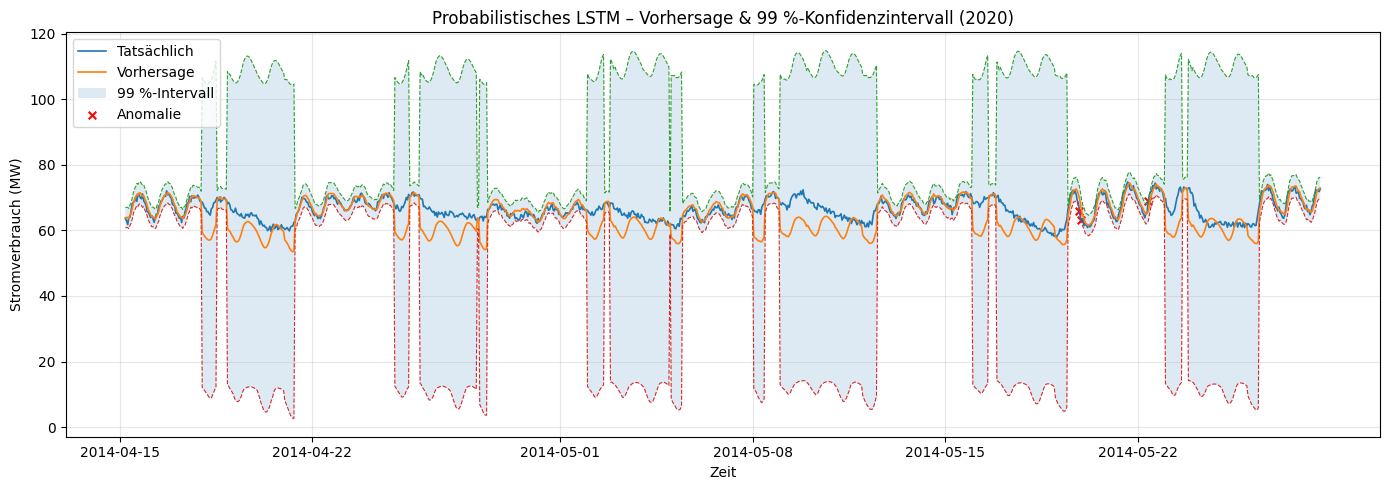

In [13]:
import tf_keras as tfk
import tensorflow_probability as tfp

tfd  = tfp.distributions
tfpl = tfp.layers



model = tfk.models.load_model(
    "model_prob.keras",
    custom_objects={
        "Normal": tfd.Normal,
        "IndependentNormal": tfpl.IndependentNormal,
    },
    compile=False,
    safe_mode=False,          #  <- hier!
)

# -----------------------------------------------------------------------------
# 6) Vorhersage + Konfidenzintervall
# -----------------------------------------------------------------------------
dist_test = model(X_test, training=False)  # tfd.Normal
mu_test = dist_test.mean().numpy().flatten()
sigma_test = dist_test.stddev().numpy().flatten()

z = 3.0  # 99 %
lower = mu_test - z * sigma_test
upper = mu_test + z * sigma_test

# Anomalien: außerhalb des Intervalls
anomalies = (y_test.flatten() < lower) | (y_test.flatten() > upper)
print("Anomalien (Summe):", anomalies.sum())

# -----------------------------------------------------------------------------
# 7) Rückskalieren
# -----------------------------------------------------------------------------
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
mu_test_inv = scaler.inverse_transform(mu_test.reshape(-1, 1)).flatten()
lower_inv = scaler.inverse_transform(lower.reshape(-1, 1)).flatten()
upper_inv = scaler.inverse_transform(upper.reshape(-1, 1)).flatten()

# -----------------------------------------------------------------------------
# 8) Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(14, 5))
idx = test_series.index[lookback:]
plt.plot(idx, y_test_inv, label="Tatsächlich")
plt.plot(idx, mu_test_inv, label="Vorhersage", alpha=0.8)
plt.fill_between(idx, lower_inv, upper_inv, alpha=0.2, label="99 % PI")
plt.scatter(idx[anomalies], y_test_inv[anomalies], color="red", marker="x", label="Anomalie")
plt.title("Probabilistische LSTM‑Vorhersage & Anomalieerkennung (2020)")
plt.xlabel("Zeit")
plt.ylabel("Stromverbrauch (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 5))

# Messwerte und Mittelwert
plt.plot(idx, y_test_inv,      label="Tatsächlich",  linewidth=1.2)
plt.plot(idx, mu_test_inv,     label="Vorhersage",   linewidth=1.2)

# Konfidenzintervall
plt.fill_between(idx,
                 lower_inv, upper_inv,
                 alpha=0.15,                 # weniger Deckkraft
                 linewidth=0,                # keine Umrandung
                 label="99 %-Intervall")
plt.plot(idx, upper_inv, linestyle="--", linewidth=0.8)   # obere Grenze
plt.plot(idx, lower_inv, linestyle="--", linewidth=0.8)   # untere Grenze

# Anomaliepunkte
plt.scatter(idx[anomalies], y_test_inv[anomalies],
            color="red", marker="x", s=30, label="Anomalie")

plt.title("Probabilistisches LSTM – Vorhersage & 99 %-Konfidenzintervall (2020)")
plt.xlabel("Zeit")
plt.ylabel("Stromverbrauch (MW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Ende
# -----------------------------------------------------------------------------


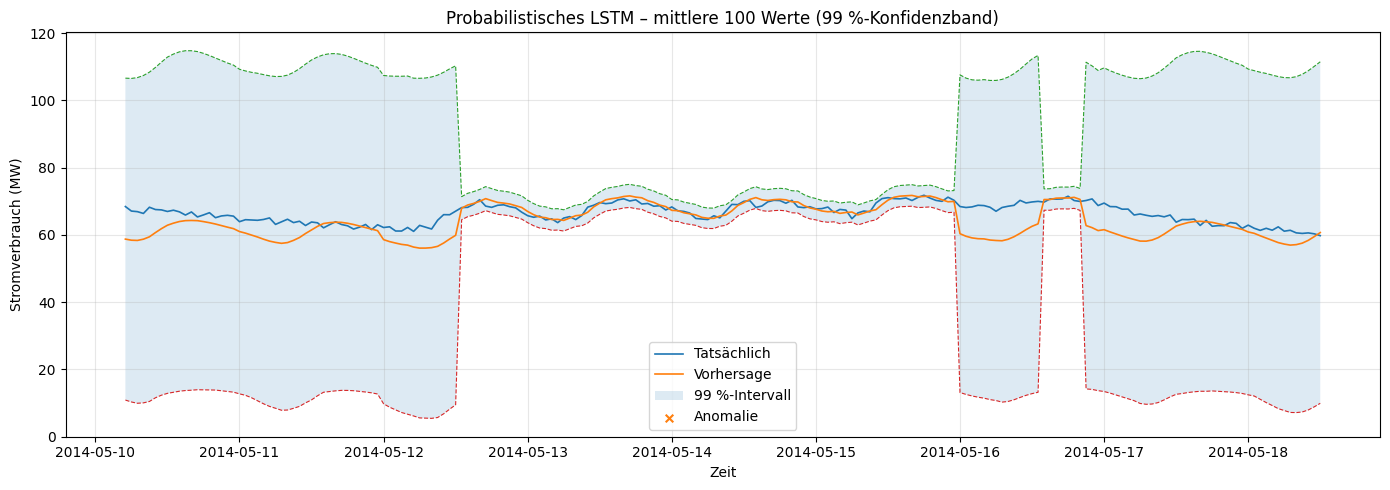

In [14]:
import matplotlib.pyplot as plt

# --- mittlere 100 Indizes bestimmen ------------------------------------------
index = 600
start = index
end   = index + 200

# --- Ausschnitte -------------------------------------------------------------
idx_slice    = idx[start:end]
y_slice      = y_test_inv[start:end]
mu_slice     = mu_test_inv[start:end]
lower_slice  = lower_inv[start:end]
upper_slice  = upper_inv[start:end]
anom_slice   = anomalies[start:end]

# --- Plot --------------------------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(idx_slice, y_slice,      label="Tatsächlich", linewidth=1.2)
plt.plot(idx_slice, mu_slice,     label="Vorhersage",  linewidth=1.2)

plt.fill_between(idx_slice, lower_slice, upper_slice,
                 alpha=0.15, linewidth=0, label="99 %-Intervall")
plt.plot(idx_slice, upper_slice, linestyle="--", linewidth=0.8)
plt.plot(idx_slice, lower_slice, linestyle="--", linewidth=0.8)

plt.scatter(idx_slice[anom_slice], y_slice[anom_slice],
            marker="x", s=30, label="Anomalie")

plt.title("Probabilistisches LSTM – mittlere 100 Werte (99 %-Konfidenzband)")
plt.xlabel("Zeit")
plt.ylabel("Stromverbrauch (MW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# IsolationForest zur anomalie erkennung

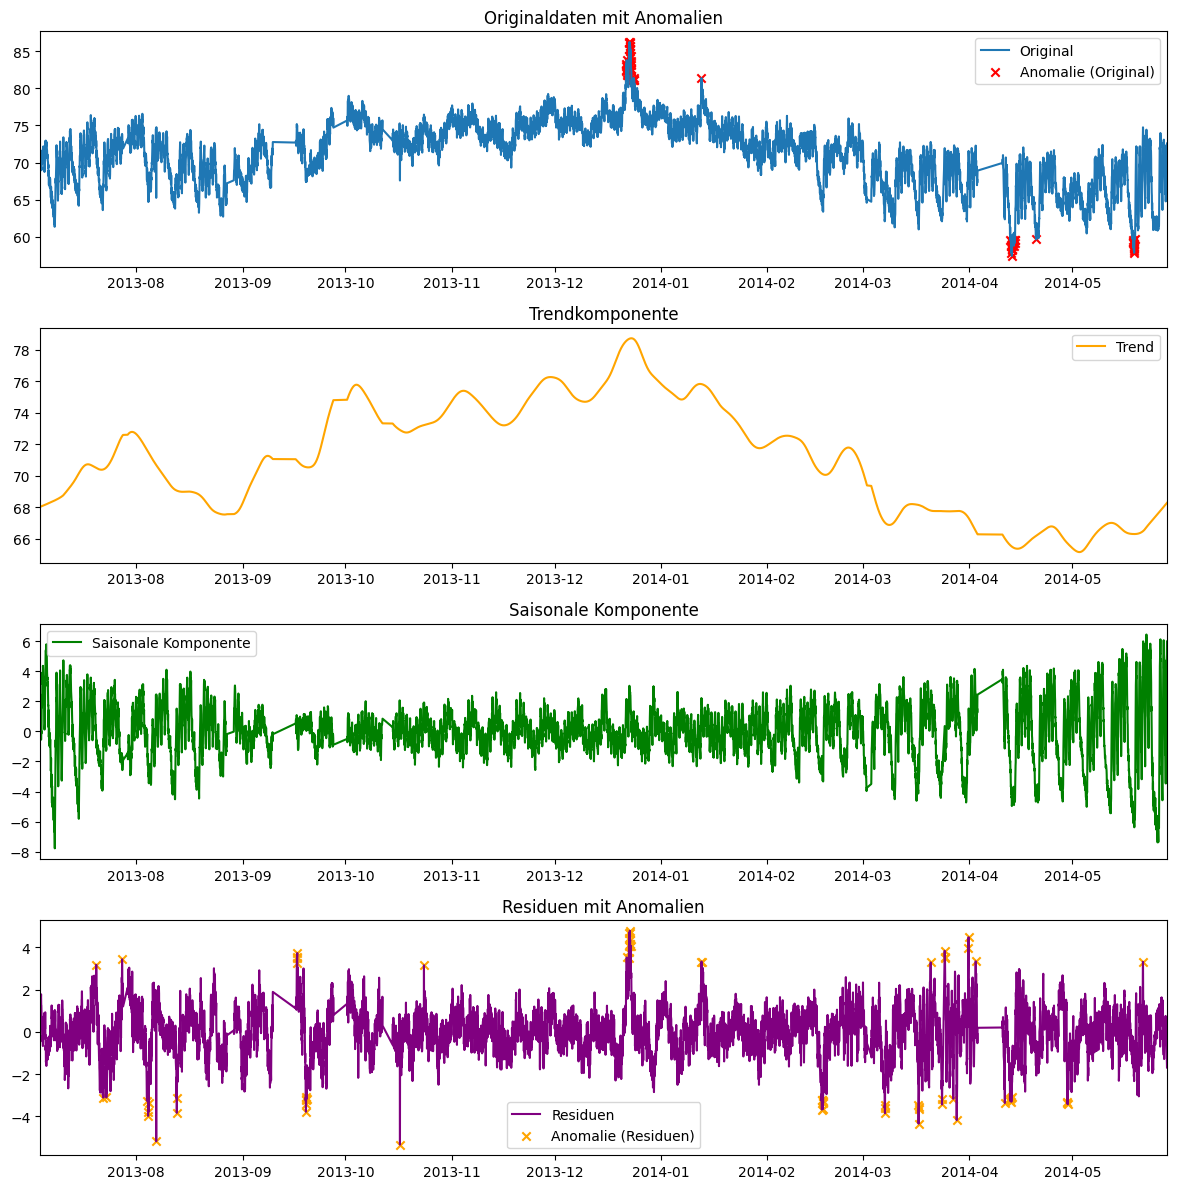

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL

# --- Series vorbereiten (angenommen series ist eine pandas.Series mit Zeitindex)
df = pd.DataFrame({'value': series})

# Fourier-Analyse zur Schätzung der dominanten Periode
x = df['value'].values - np.mean(df['value'].values)
fft = np.fft.fft(x)
frequencies = np.fft.fftfreq(len(x))
amplitudes = np.abs(fft)

# Nur positive Frequenzen ohne DC-Anteil
positive_freqs = frequencies[1:len(frequencies)//2]
positive_amps = amplitudes[1:len(amplitudes)//2]

# Filtere sinnvolle Frequenzen > 0
valid_mask = positive_freqs > 1e-8
valid_freqs = positive_freqs[valid_mask]
valid_amps = positive_amps[valid_mask]

# Dominante Frequenz und Periode bestimmen
dominant_index = np.argmax(valid_amps)
dominant_freq = valid_freqs[dominant_index]
dominant_period = int(round(1 / dominant_freq))
contamination = 0.01  # Kontaminationsrate für Isolation Forest

# Zerlege Zeitreihe mit STL
stl = STL(df['value'], period=168)
stl_result = stl.fit()
seasonal, trend, resid = stl_result.seasonal, stl_result.trend, stl_result.resid

# === Isolation Forest auf Originaldaten ===
iso_orig = IsolationForest(contamination=contamination, random_state=42)
df['anomaly_orig'] = iso_orig.fit_predict(df[['value']])

# === Isolation Forest auf Residuen ===
iso_resid = IsolationForest(contamination=contamination, random_state=42)
resid_data = resid.values.reshape(-1, 1)
resid_pred = iso_resid.fit_predict(resid_data)

# Anomalie-Ergebnisse der Residuen in df speichern
anomaly_resid_series = pd.Series(resid_pred, index=resid.index)
df['anomaly_resid'] = np.nan
df.loc[anomaly_resid_series.index, 'anomaly_resid'] = anomaly_resid_series

# === Visualisierung ===
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=False)

# Plot Originaldaten
axs[0].plot(df.index, df['value'], label='Original')
axs[0].scatter(df.index[df['anomaly_orig'] == -1], df['value'][df['anomaly_orig'] == -1],
               color='red', label='Anomalie (Original)', marker='x')
axs[0].set_title("Originaldaten mit Anomalien")
axs[0].legend()
axs[0].set_xlim(df.index.min(), df.index.max())

# Plot Trend
axs[1].plot(trend.index, trend.values, label='Trend', color='orange')
axs[1].set_title("Trendkomponente")
axs[1].legend()
axs[1].set_xlim(trend.index.min(), trend.index.max())

# Plot Saisonale Komponente
axs[2].plot(seasonal.index, seasonal.values, label='Saisonale Komponente', color='green')
axs[2].set_title("Saisonale Komponente")
axs[2].legend()
axs[2].set_xlim(seasonal.index.min(), seasonal.index.max())

# Plot Residuen mit Anomalien
axs[3].plot(resid.index, resid.values, label='Residuen', color='purple')
resid_anomaly_mask = resid_pred == -1
axs[3].scatter(resid.index[resid_anomaly_mask], resid.values[resid_anomaly_mask],
               color='orange', label='Anomalie (Residuen)', marker='x')
axs[3].set_title("Residuen mit Anomalien")
axs[3].legend()
axs[3].set_xlim(resid.index.min(), resid.index.max())

plt.tight_layout()
plt.show()

anomalien zeiten: timestamp
2013-07-27 21:00:00    3.434838
2013-08-04 11:00:00   -3.975021
2013-08-04 13:00:00   -3.791992
2013-08-04 15:00:00   -3.360551
2013-08-06 20:00:00   -5.176980
2013-08-12 20:00:00   -3.831834
2013-09-16 21:00:00    3.507677
2013-09-16 22:00:00    3.557277
2013-09-16 23:00:00    3.730115
2013-09-19 12:00:00   -3.778634
2013-09-19 13:00:00   -3.407259
2013-10-16 22:00:00   -5.333984
2013-12-22 01:00:00    3.521264
2013-12-22 16:00:00    3.485821
2013-12-22 17:00:00    4.063126
2013-12-22 18:00:00    3.763830
2013-12-22 19:00:00    4.679895
2013-12-22 20:00:00    4.459406
2013-12-22 21:00:00    4.669166
2013-12-22 22:00:00    4.156231
2013-12-22 23:00:00    4.785380
2013-12-23 00:00:00    4.156639
2013-12-23 01:00:00    4.358455
2013-12-23 03:00:00    4.076707
2013-12-23 05:00:00    4.068896
2014-02-16 23:00:00   -3.675877
2014-02-17 06:00:00   -3.656377
2014-02-17 08:00:00   -3.368331
2014-03-07 07:00:00   -3.602763
2014-03-07 08:00:00   -3.477645
2014-03-07 0

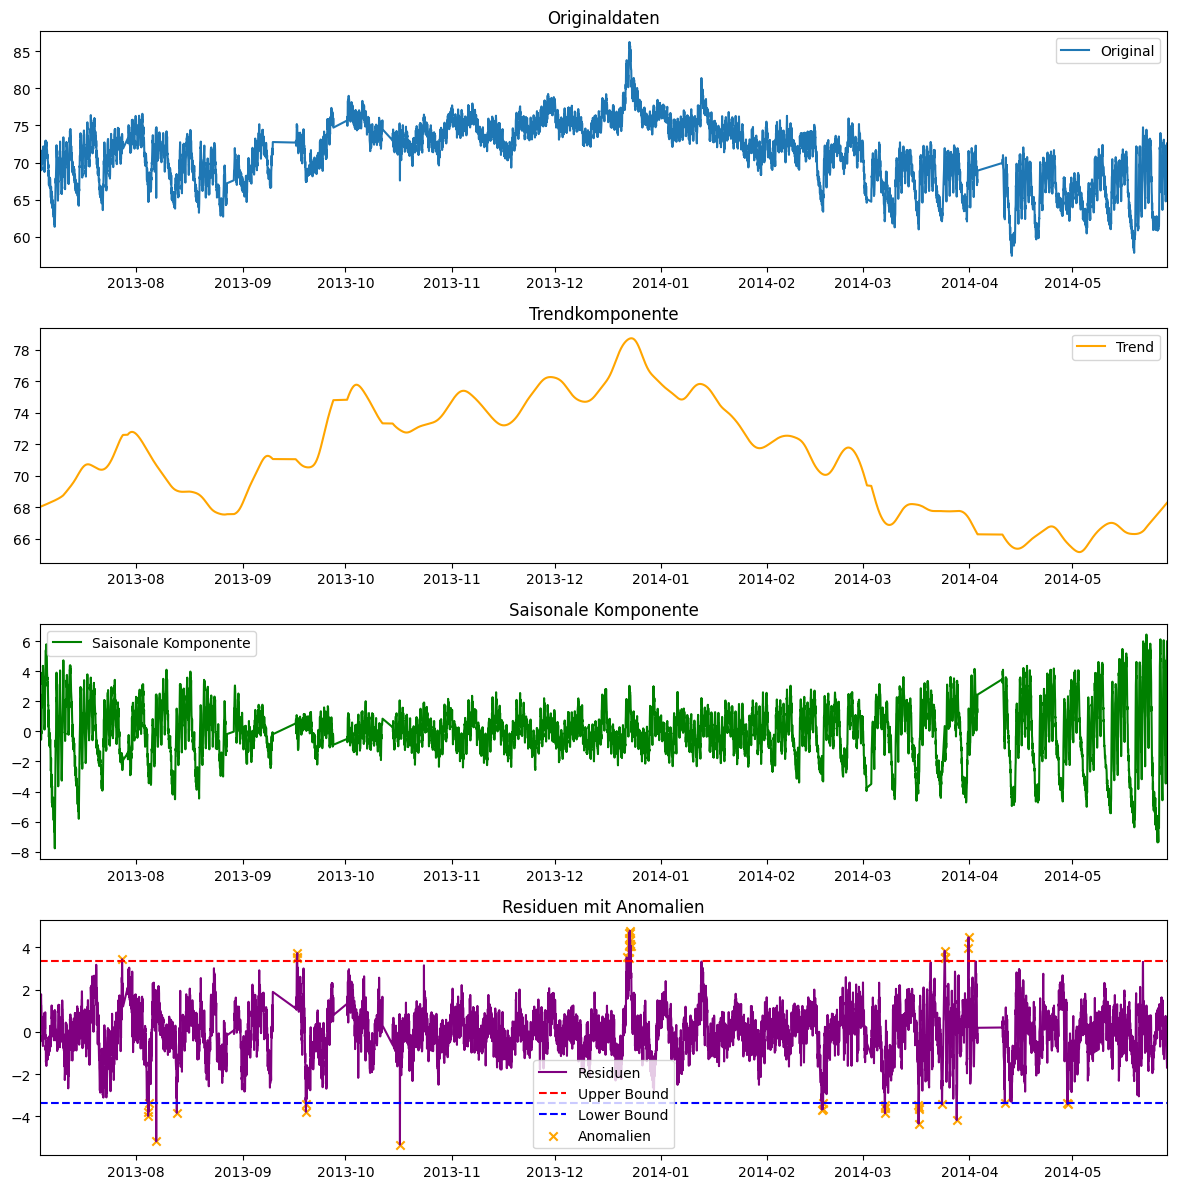

Anzahl der Anomalien: 45


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# --- Series vorbereiten (angenommen series ist eine pandas.Series mit Zeitindex)
df = pd.DataFrame({'value': series})

# Fourier-Analyse zur Schätzung der dominanten Periode
x = df['value'].values - np.mean(df['value'].values)
fft = np.fft.fft(x)
frequencies = np.fft.fftfreq(len(x))
amplitudes = np.abs(fft)

# Nur positive Frequenzen ohne DC-Anteil
positive_freqs = frequencies[1:len(frequencies)//2]
positive_amps = amplitudes[1:len(amplitudes)//2]

# Filtere sinnvolle Frequenzen > 0
valid_mask = positive_freqs > 1e-8
valid_freqs = positive_freqs[valid_mask]
valid_amps = positive_amps[valid_mask]

# Dominante Frequenz und Periode bestimmen
dominant_index = np.argmax(valid_amps)
dominant_freq = valid_freqs[dominant_index]
dominant_period = int(round(1 / dominant_freq))

# Zerlege Zeitreihe mit STL
stl = STL(df['value'], period=168)
stl_result = stl.fit()
seasonal, trend, resid = stl_result.seasonal, stl_result.trend, stl_result.resid

# Berechnung der Anomaliegrenzen
mean_resid = resid.mean()
std_resid = resid.std()
upper_bound = mean_resid + 3 * std_resid
lower_bound = mean_resid - 3 * std_resid

# Identifikation der Anomalien
anomalies = resid[(resid > upper_bound) | (resid < lower_bound)]
print(f"anomalien zeiten: {anomalies} ")
# === Visualisierung ===
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=False)

# Plot Originaldaten
axs[0].plot(df.index, df['value'], label='Original')
axs[0].set_title("Originaldaten")
axs[0].legend()
axs[0].set_xlim(df.index.min(), df.index.max())

# Plot Trend
axs[1].plot(trend.index, trend.values, label='Trend', color='orange')
axs[1].set_title("Trendkomponente")
axs[1].legend()
axs[1].set_xlim(trend.index.min(), trend.index.max())

# Plot Saisonale Komponente
axs[2].plot(seasonal.index, seasonal.values, label='Saisonale Komponente', color='green')
axs[2].set_title("Saisonale Komponente")
axs[2].legend()
axs[2].set_xlim(seasonal.index.min(), seasonal.index.max())

# Plot Residuen mit Anomalien
axs[3].plot(resid.index, resid.values, label='Residuen', color='purple')
axs[3].axhline(upper_bound, color='red', linestyle='--', label='Upper Bound')
axs[3].axhline(lower_bound, color='blue', linestyle='--', label='Lower Bound')
axs[3].scatter(anomalies.index, anomalies.values, color='orange', label='Anomalien', marker='x')
axs[3].set_title("Residuen mit Anomalien")
axs[3].legend()
axs[3].set_xlim(resid.index.min(), resid.index.max())

plt.tight_layout()
plt.show()
print(f"Anzahl der Anomalien: {len(anomalies)}")

anzahl der Anomalien: 37


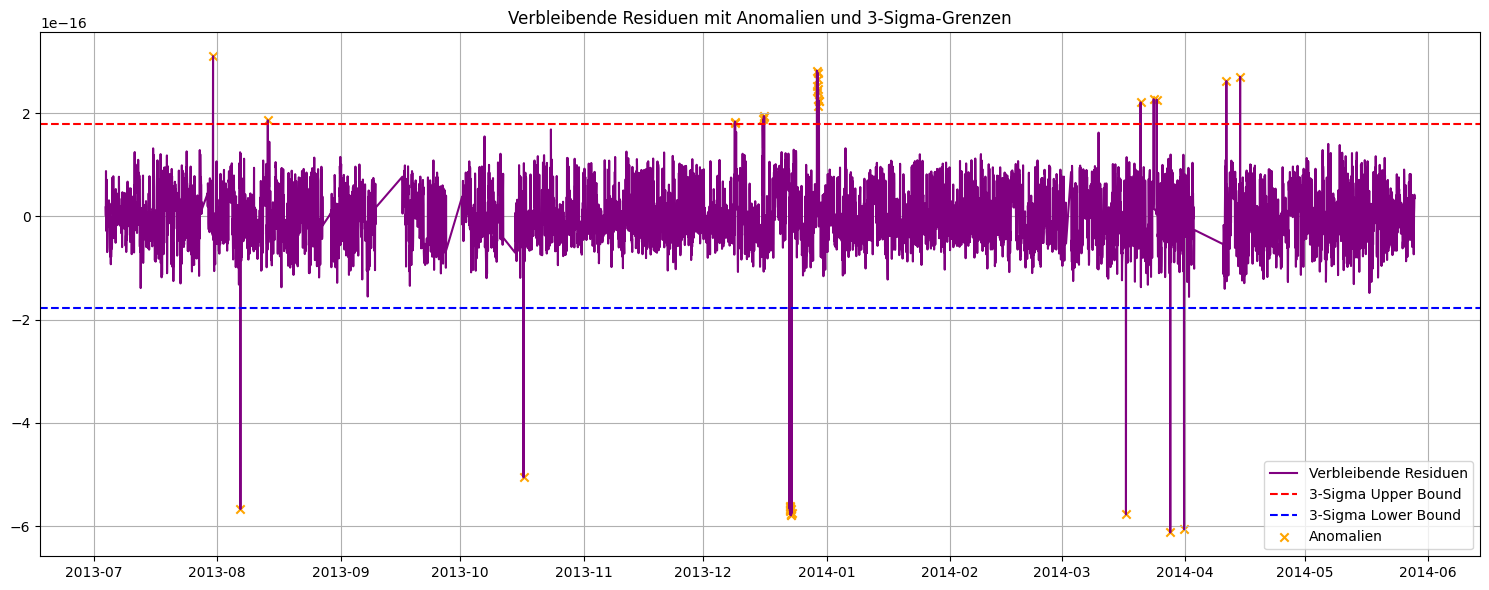

In [17]:
from statsmodels.tsa.seasonal import STL

# Berechnung der 10 dominantesten Perioden
top_indices = np.argsort(valid_amps)[-2:][::-1]
top_frequencies = valid_freqs[top_indices]
top_periods = [int(round(1 / freq)) for freq in top_frequencies]

# Iteration über die 10 dominantesten Perioden
remaining_resid = resid.copy()
all_anomalies = []

for period in top_periods:
    try:
        # Zerlege die Residuen mit STL für die aktuelle Periode
        stl_resid = STL(remaining_resid, period=period)
        stl_resid_result = stl_resid.fit()

    

        # Aktualisiere die verbleibenden Residuen
        remaining_resid = stl_resid_result.resid

    except Exception as e:
        print(f"Fehler bei Periode {period}: {e}")
        continue

# Berechnung der Anomaliegrenzen für die detrendierten Residuen
mean_detrended = remaining_resid.mean()
std_detrended = remaining_resid.std()
upper_bound_detrended = mean_detrended + 3 * std_detrended
lower_bound_detrended = mean_detrended - 3 * std_detrended

# Identifikation der Anomalien in den detrendierten Residuen
all_anomalies = remaining_resid[
    (remaining_resid > upper_bound_detrended) | (remaining_resid < lower_bound_detrended)
]
print(f"anzahl der Anomalien: {len(all_anomalies)}")
# Visualisierung der verbleibenden Residuen, Anomalien und 3-Sigma-Grenzen
plt.figure(figsize=(15, 6))
plt.plot(remaining_resid.index, remaining_resid.values, label='Verbleibende Residuen', color='purple')
plt.axhline(upper_bound_detrended, color='red', linestyle='--', label='3-Sigma Upper Bound')
plt.axhline(lower_bound_detrended, color='blue', linestyle='--', label='3-Sigma Lower Bound')
plt.scatter(all_anomalies.index, all_anomalies.values, color='orange', label='Anomalien', marker='x')
plt.title("Verbleibende Residuen mit Anomalien und 3-Sigma-Grenzen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

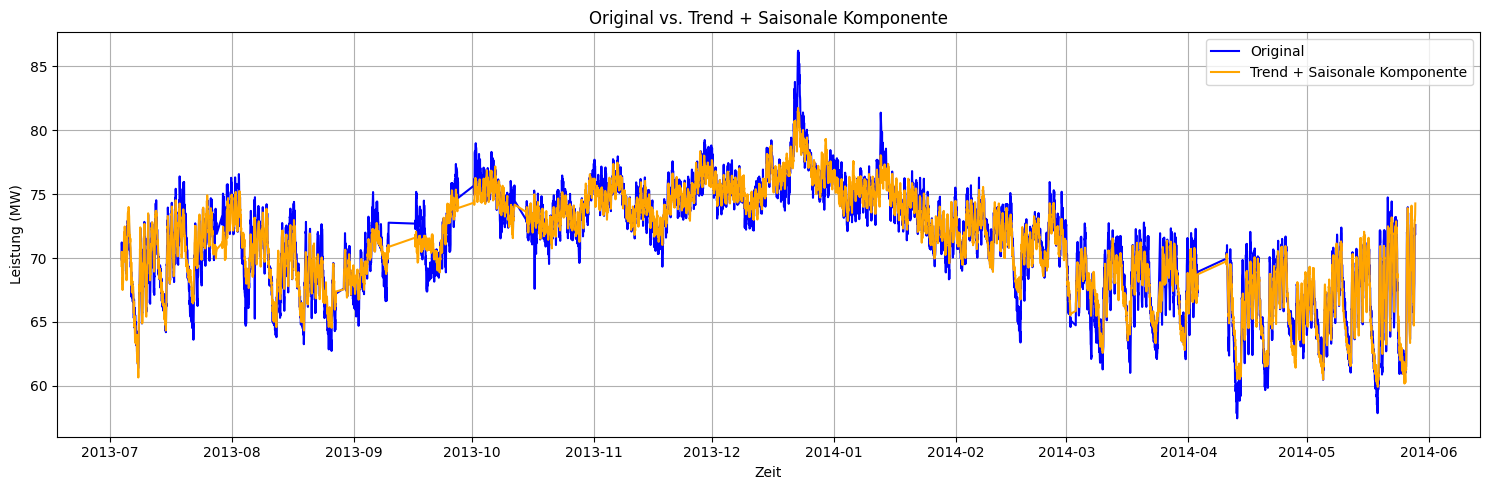

In [18]:
# plot trend + sesonal vs original

trend_seasonal = trend + seasonal
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['value'], label='Original', color='blue')
plt.plot(trend_seasonal.index, trend_seasonal.values, label='Trend + Saisonale Komponente', color='orange')
plt.title("Original vs. Trend + Saisonale Komponente")
plt.xlabel("Zeit")
plt.ylabel("Leistung (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


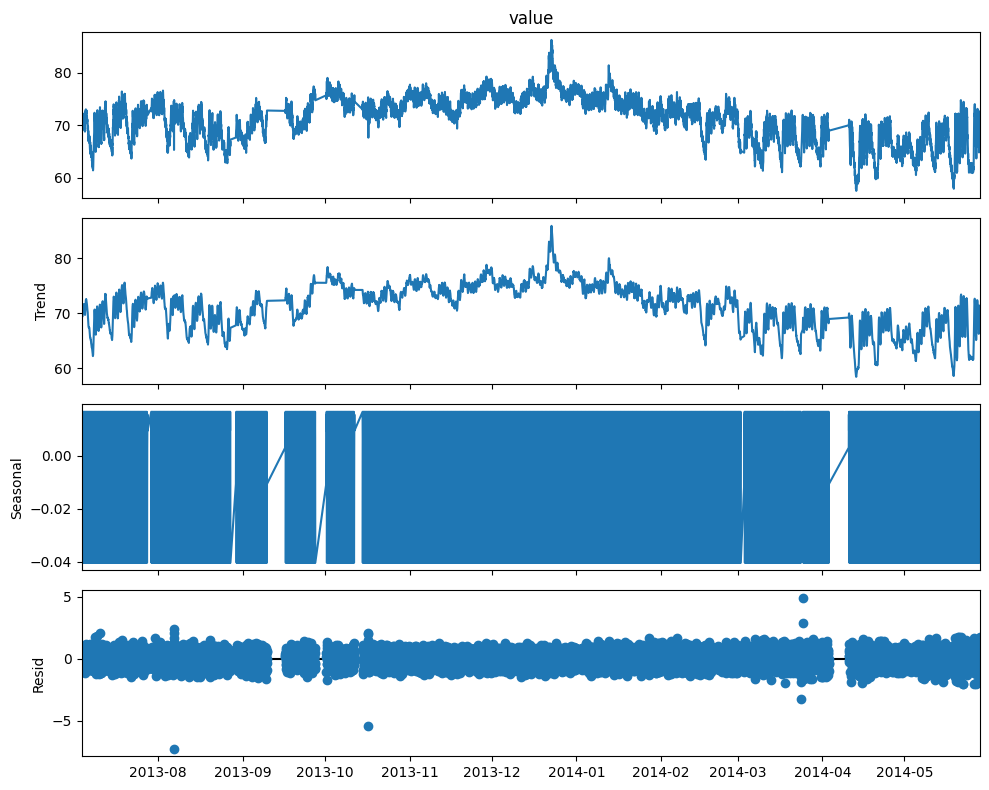

In [19]:
decompose_result = seasonal_decompose(series, model="additive", period=7)
fig = decompose_result.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# 4. STL-Zerlegung (robust, lokal)

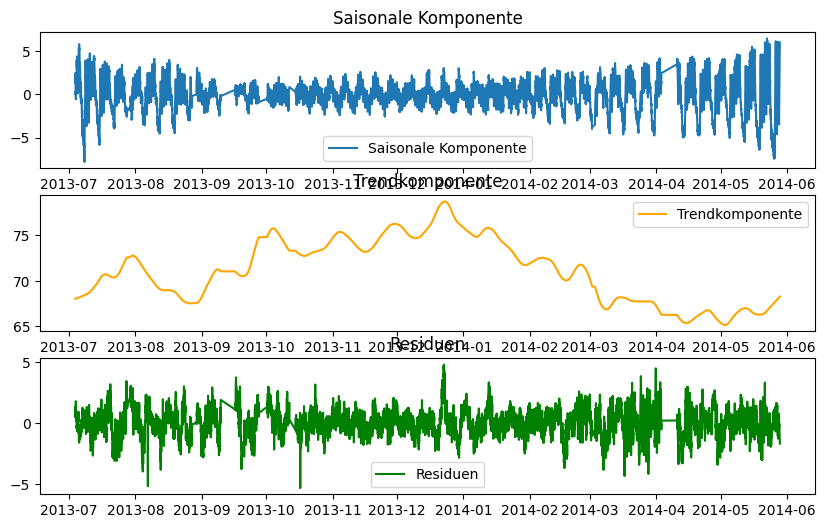

In [21]:
stl = STL(series, period=168)
stl_result = stl.fit()
seasonal, trend, resid = stl_result.seasonal, stl_result.trend, stl_result.resid
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(seasonal, label='Saisonale Komponente')
plt.title('Saisonale Komponente')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(trend, label='Trendkomponente', color='orange')
plt.title('Trendkomponente')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(resid, label='Residuen', color='green')
plt.title('Residuen')
plt.legend()

# 6. Fourier-Transformation zur Frequenzanalyse

Dominante Frequenz: 0.0001376083665886886
Geschätzte Periode: 7267
Dominante Frequenz: 0.0001376083665886886
Geschätzte Periode: 7267
Top 5 dominante Frequenzen und Perioden:
Top 1: Frequenz = 0.00014, Amplitude = 16252.51, Periode = 7267.00
Top 2: Frequenz = 0.00028, Amplitude = 4277.04, Periode = 3633.50
Top 3: Frequenz = 0.00055, Amplitude = 3662.99, Periode = 1816.75
Top 4: Frequenz = 0.00605, Amplitude = 4280.29, Periode = 165.16
Top 5: Frequenz = 0.00619, Amplitude = 3227.03, Periode = 161.49


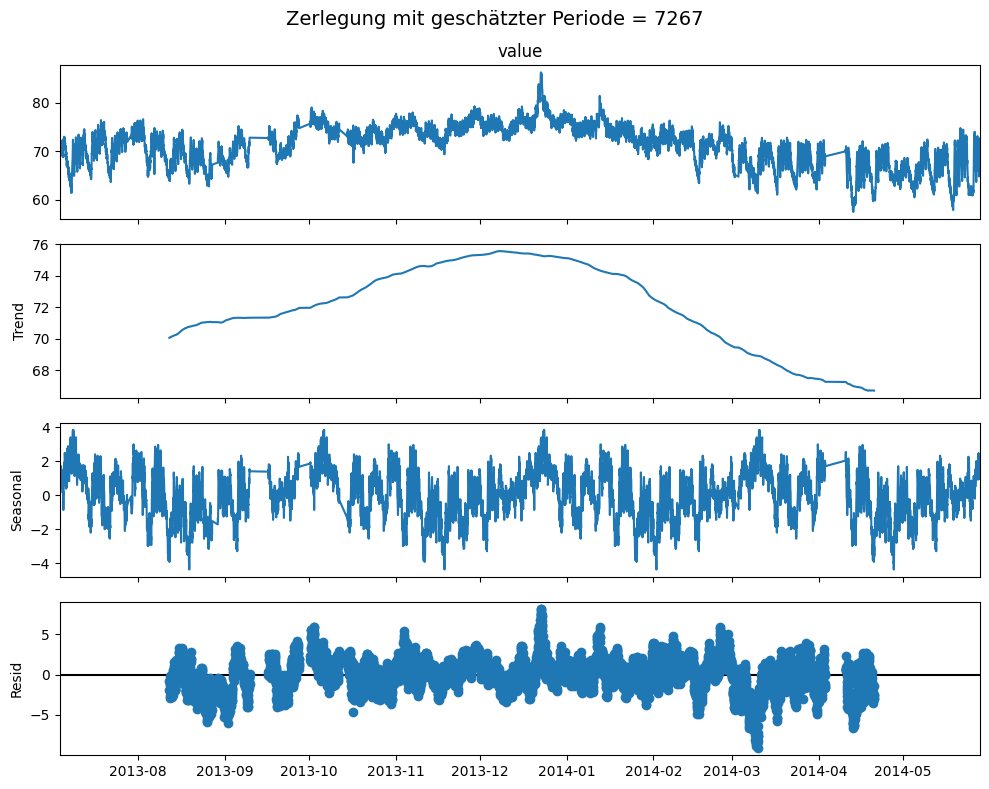

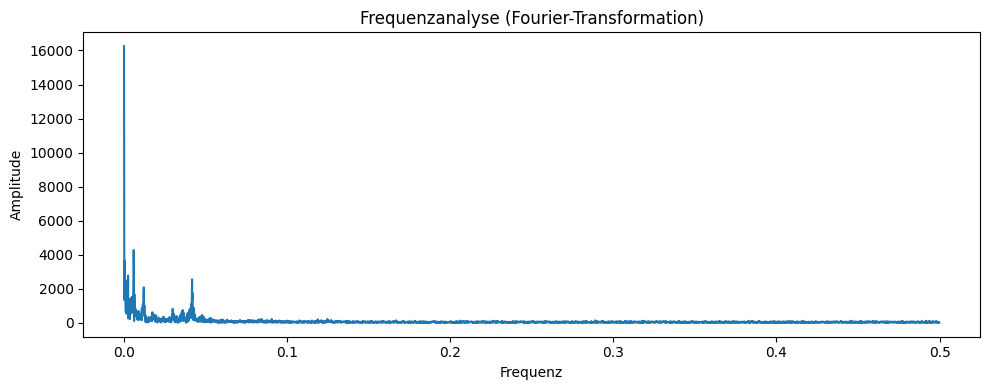

In [25]:
x = series.values - np.mean(series.values)
fft = np.fft.fft(x)
frequencies = np.fft.fftfreq(len(x))
amplitudes = np.abs(fft)
positive_freqs = frequencies[1:len(frequencies)//2]
positive_amps = amplitudes[1:len(amplitudes)//2]

# Index der größten Amplitude finden
dominant_index = np.argmax(positive_amps)
dominant_freq = positive_freqs[dominant_index]

# Frequenz in Periode umrechnen (Periode = 1 / f)
dominant_period = int(round(1 / dominant_freq))

print(f"Dominante Frequenz: {dominant_freq}")
print(f"Geschätzte Periode: {dominant_period}")


valid_mask = positive_freqs > 1e-8  
valid_freqs = positive_freqs[valid_mask]
valid_amps = positive_amps[valid_mask]

valid_amps = positive_amps[valid_mask].ravel()
valid_freqs = positive_freqs[valid_mask].ravel()

dominant_index = np.argmax(valid_amps)
dominant_freq = valid_freqs[dominant_index]
dominant_period = int(round(1 / dominant_freq))

print(f"Dominante Frequenz: {dominant_freq}")
print(f"Geschätzte Periode: {dominant_period}")

# Get top 5 amplitudes
unique_indices = np.unique(np.argsort(valid_amps)[-5:][::-1])
top_frequencies = valid_freqs[unique_indices]
top_amplitudes = valid_amps[unique_indices]
top_periods = [1 / freq for freq in top_frequencies]

print("Top 5 dominante Frequenzen und Perioden:")
for i, (freq, amp, period) in enumerate(zip(top_frequencies, top_amplitudes, top_periods), start=1):
    print(f"Top {i}: Frequenz = {freq:.5f}, Amplitude = {amp:.2f}, Periode = {period:.2f}")


    
result = seasonal_decompose(series, model="additive", period=1816)

# Plot der Zerlegung
fig = result.plot()
fig.set_size_inches(10, 8)
plt.suptitle(f"Zerlegung mit geschätzter Periode = {dominant_period}", fontsize=14)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(frequencies[1:len(x)//2], amplitudes[1:len(x)//2])
plt.title("Frequenzanalyse (Fourier-Transformation)")
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

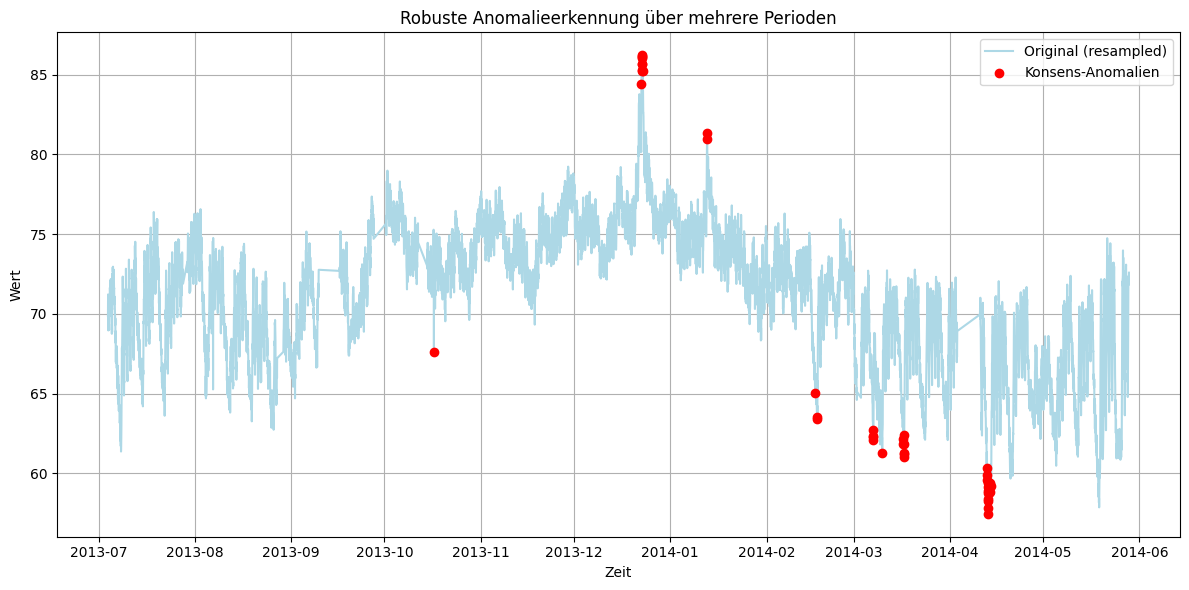

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Speichere Anomalie-Indizes pro Zerlegung
anomaly_sets = []

for period in top_periods:
    try:
        period = int(round(period))
        if period < 2 or period >= len(series) // 2:
            continue  # skip unrealistische Perioden
        
        result = seasonal_decompose(series, model="additive", period=period)
        residual = result.resid.dropna()
        z_scores = (residual - residual.mean()) / residual.std()
        anomalies = residual[np.abs(z_scores) > 2]
        anomaly_sets.append(set(anomalies.index))
    except Exception as e:
        print(f"Fehler bei Periode {period}: {e}")
        continue

# Schnittmenge aller Anomalien berechnen (Konsens über alle Perioden)
if anomaly_sets:
    consensus_anomalies = set.intersection(*anomaly_sets)
else:
    consensus_anomalies = set()

# Plotten
plt.figure(figsize=(12, 6))
plt.plot(series, label="Original (resampled)", color="lightblue")
plt.scatter(list(consensus_anomalies), series.loc[list(consensus_anomalies)], 
            color="red", label="Konsens-Anomalien", zorder=5)
plt.title("Robuste Anomalieerkennung über mehrere Perioden")
plt.xlabel("Zeit")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


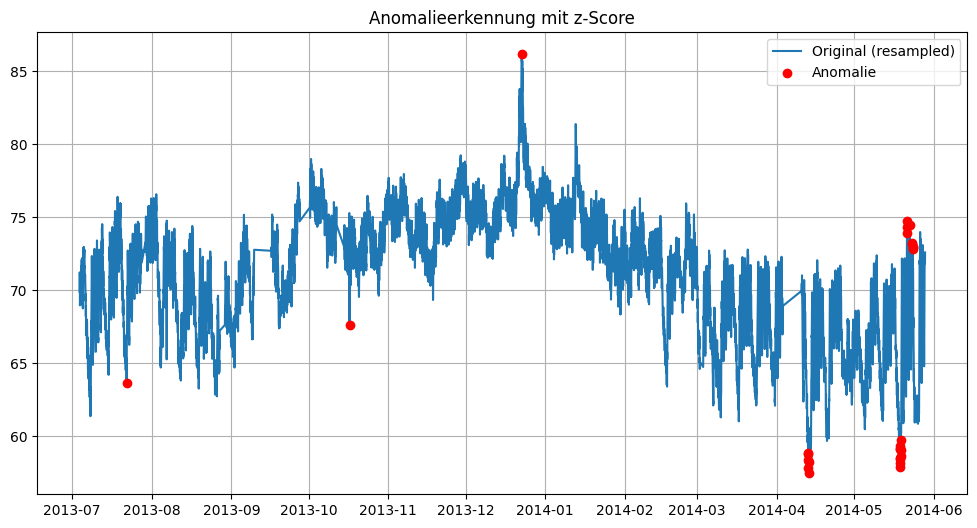

In [27]:
residual = result.resid.dropna()
z_scores = (residual - residual.mean()) / residual.std()
anomalies = residual[np.abs(z_scores) > 3]
plt.figure(figsize=(12, 6))
plt.plot(series, label="Original (resampled)")
plt.scatter(anomalies.index, series.loc[anomalies.index], color="red", label="Anomalie", zorder=5)
plt.title("Anomalieerkennung mit z-Score")
plt.legend()
plt.grid(True)
plt.show()


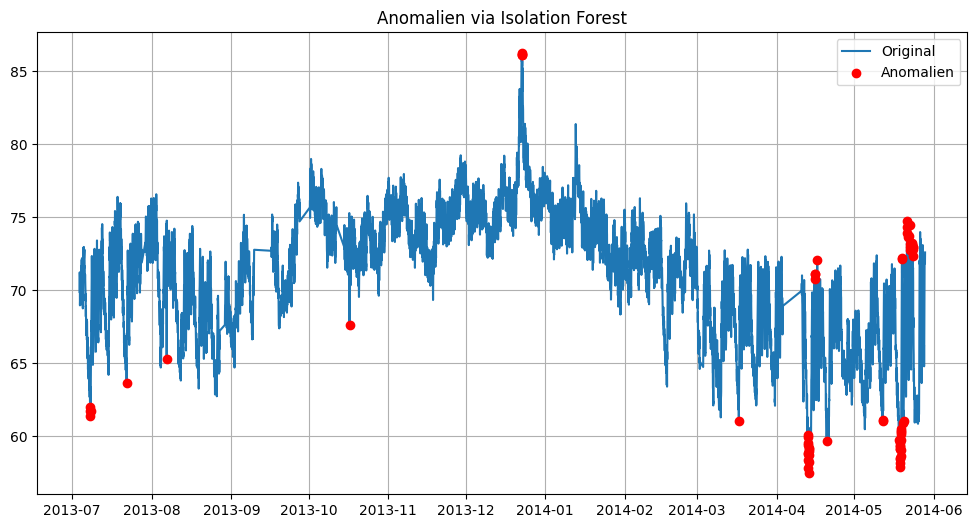

In [28]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Vorbereitung
X = residual.values.reshape(-1, 1)

# Modell
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X)
scores = model.decision_function(X)
outliers = model.predict(X)

# Anomalien extrahieren
anomalies = residual[outliers == -1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series, label="Original")
plt.scatter(anomalies.index, series.loc[anomalies.index], color="red", label="Anomalien", zorder=5)
plt.title("Anomalien via Isolation Forest")
plt.legend()
plt.grid(True)
plt.show()
